Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 64, 66)            264       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 32, 66)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 33)            6567      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 15, 33)            0         
 g1D)                                                            
                                                                 
 global_average_pooling1d_2  (None, 33)                0         
  (GlobalAveragePooling1D)                                       
                                                      

919/921 [============================>.] - ETA: 0s - loss: 0.9708 - accuracy: 0.6287
Epoch 1: Test accuracy: 0.6656, Test loss: 0.8306
921/921 [==============================] - 18s 18ms/step - loss: 0.9707 - accuracy: 0.6288 - val_loss: 0.8323 - val_accuracy: 0.6651
Epoch 2/50
918/921 [============================>.] - ETA: 0s - loss: 0.7229 - accuracy: 0.7107
Epoch 2: Test accuracy: 0.7141, Test loss: 0.6777
921/921 [==============================] - 15s 16ms/step - loss: 0.7230 - accuracy: 0.7107 - val_loss: 0.6791 - val_accuracy: 0.7181
Epoch 3/50
914/921 [============================>.] - ETA: 0s - loss: 0.6198 - accuracy: 0.7476
Epoch 3: Test accuracy: 0.7479, Test loss: 0.5892
921/921 [==============================] - 17s 18ms/step - loss: 0.6194 - accuracy: 0.7480 - val_loss: 0.5954 - val_accuracy: 0.7510
Epoch 4/50
918/921 [============================>.] - ETA: 0s - loss: 0.5563 - accuracy: 0.7744
Epoch 4: Test accuracy: 0.7770, Test loss: 0.5202
921/921 [===================

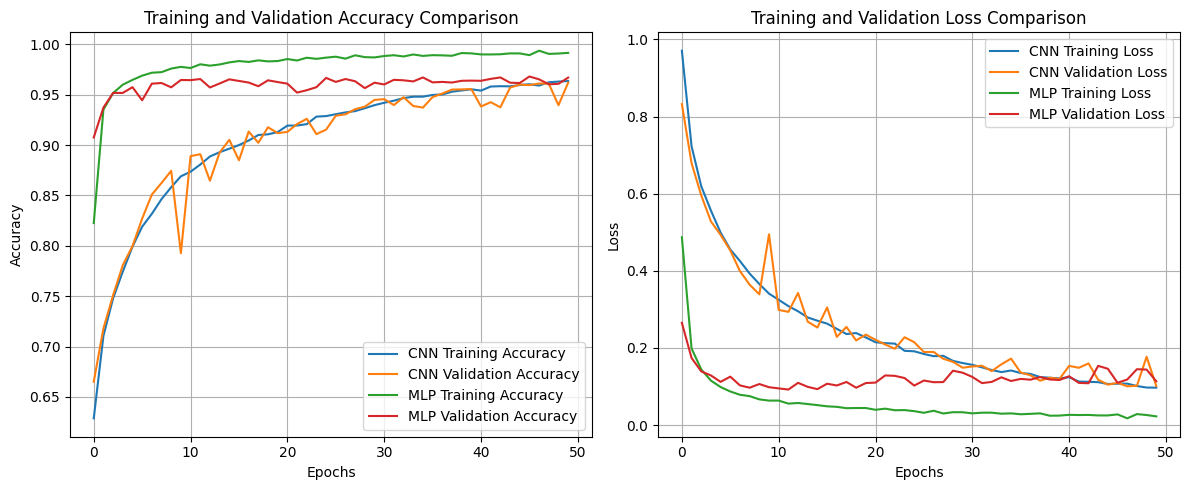

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
import pandas as pd

# Assuming df_encoded is your DataFrame with encoded features
df_encoded = pd.read_csv(r'/content/df_encoded.csv')
y = df_encoded['Approved_Flag']
X = df_encoded.drop(['Approved_Flag'], axis=1)


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 1: Split into training and combined validation + testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Step 2: Split combined validation + testing set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_val_scaled = scaler.transform(X_val)
x_test_scaled = scaler.transform(X_test)

# Reshape for 1D CNN input
x_train_cnn = np.expand_dims(x_train_scaled, axis=-1)
x_val_cnn = np.expand_dims(x_val_scaled, axis=-1)
x_test_cnn = np.expand_dims(x_test_scaled, axis=-1)

# Define the TestCallback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_accuracy = []
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        x_test, y_test = self.test_data
        loss, accuracy = self.model.evaluate(x_test, y_test, verbose=0)
        self.test_accuracy.append(accuracy)
        self.test_loss.append(loss)
        print(f'\nEpoch {epoch + 1}: Test accuracy: {accuracy:.4f}, Test loss: {loss:.4f}')

# Define the 1D CNN model
model_cnn = Sequential([
    Conv1D(66, kernel_size=3, activation='relu', input_shape=(x_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(33, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(66, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the model
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary and plot model architecture
model_cnn.summary()
plot_model(model_cnn, to_file='/content/modelcnn_architecture.png', show_shapes=True, show_layer_names=True)

# Create an instance of TestCallback
test_callback_cnn = TestCallback((x_test_cnn, y_test))

# Train the CNN model with the TestCallback
history_cnn = model_cnn.fit(x_train_cnn, y_train, epochs=50, batch_size=32,
                            validation_data=(x_val_cnn, y_val),
                            callbacks=[test_callback_cnn])

# Define the MLP model
model_mlp = Sequential([
    Dense(66, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(33, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the MLP model
model_mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary and plot model architecture
model_mlp.summary()
plot_model(model_mlp, to_file='/content/modelmlp_architecture.png', show_shapes=True, show_layer_names=True)

# Create an instance of TestCallback for MLP
test_callback_mlp = TestCallback((x_test_scaled, y_test))

# Train the MLP model with the TestCallback
history_mlp = model_mlp.fit(x_train_scaled, y_train, epochs=50, batch_size=32,
                            validation_data=(x_val_scaled, y_val),
                            callbacks=[test_callback_mlp])

# Plot training accuracy vs validation accuracy over epochs for CNN and MLP
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(history_mlp.history['accuracy'], label='MLP Training Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='MLP Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.grid(True)

# Plot training loss vs validation loss over epochs for CNN and MLP
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='CNN Training Loss')
plt.plot(history_cnn.history['val_loss'], label='CNN Validation Loss')
plt.plot(history_mlp.history['loss'], label='MLP Training Loss')
plt.plot(history_mlp.history['val_loss'], label='MLP Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/mlp_vs_cnn_training_validation.png', dpi=300, bbox_inches='tight')
plt.show()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 64, 66)            264       
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 32, 66)            0         
 ng1D)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, 30, 33)            6567      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 15, 33)            0         
 ng1D)                                                           
                                                                 
 global_average_pooling1d_4  (None, 33)                0         
  (GlobalAveragePooling1D)                                       
                                                     

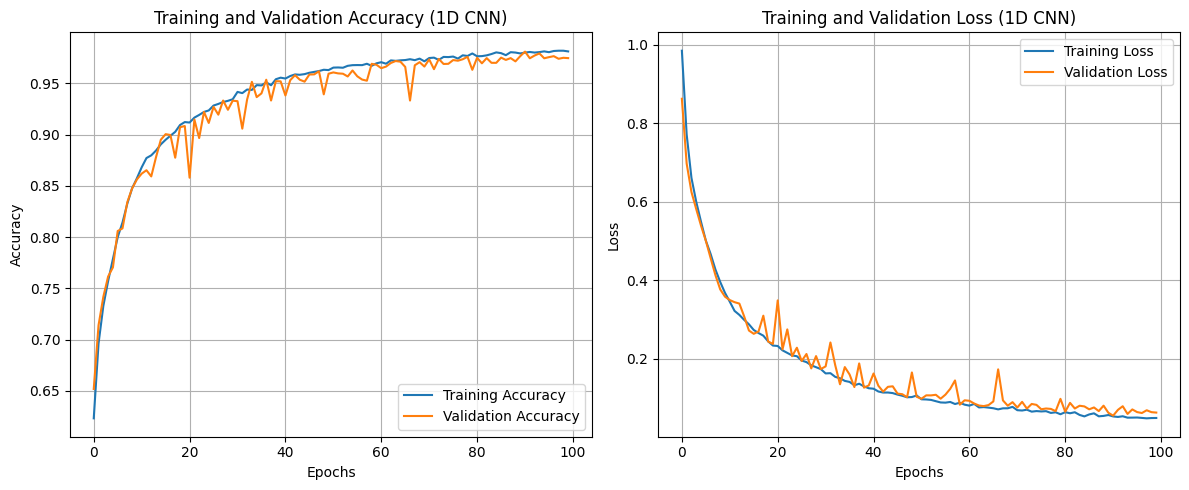

198/198 [==============================] - 1s 3ms/step
Overall Test Accuracy: 0.9765
Class p1:
Precision: 0.9410288582183187
Recall: 0.967741935483871
F1 Score: 0.9541984732824428

Class p2:
Precision: 0.9856471816283925
Recall: 0.9955192409066947
F1 Score: 0.9905586152635719

Class p3:
Precision: 0.9728813559322034
Recall: 0.895010395010395
F1 Score: 0.9323226854358418

Class p4:
Precision: 0.9723618090452262
Recall: 0.993581514762516
F1 Score: 0.9828571428571429

Overall Precision: 0.9680
Overall Recall: 0.9630
Overall F1 Score: 0.9650


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# Assuming df_encoded is your DataFrame with encoded features
df_encoded = pd.read_csv(r'/content/df_encoded.csv')
y = df_encoded['Approved_Flag']
X = df_encoded.drop(['Approved_Flag'], axis=1)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 1: Split into training and combined validation + testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Step 2: Split combined validation + testing set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_val_scaled = scaler.transform(X_val)
x_test_scaled = scaler.transform(X_test)

# Reshape for 1D CNN input
x_train_cnn = np.expand_dims(x_train_scaled, axis=-1)
x_val_cnn = np.expand_dims(x_val_scaled, axis=-1)
x_test_cnn = np.expand_dims(x_test_scaled, axis=-1)

# Define the TestCallback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_accuracy = []
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        x_test, y_test = self.test_data
        loss, accuracy = self.model.evaluate(x_test, y_test, verbose=0)
        self.test_accuracy.append(accuracy)
        self.test_loss.append(loss)
        print(f'\nEpoch {epoch + 1}: Test accuracy: {accuracy:.4f}, Test loss: {loss:.4f}')

# Define the 1D CNN model
model_cnn = Sequential([
    Conv1D(66, kernel_size=3, activation='relu', input_shape=(x_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(33, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(66, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the model
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary and plot model architecture
model_cnn.summary()
plot_model(model_cnn, to_file='/content/modelcnn_architecture.png', show_shapes=True, show_layer_names=True)

# Create an instance of TestCallback
test_callback_cnn = TestCallback((x_test_cnn, y_test))

# Train the CNN model with the TestCallback for 100 epochs
history_cnn = model_cnn.fit(x_train_cnn, y_train, epochs=100, batch_size=32,
                            validation_data=(x_val_cnn, y_val),
                            callbacks=[test_callback_cnn])

# Plot training accuracy vs validation accuracy over epochs for CNN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (1D CNN)')
plt.legend()
plt.grid(True)

# Plot training loss vs validation loss over epochs for CNN
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (1D CNN)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/cnn_training_validation.png', dpi=300, bbox_inches='tight')
plt.show()

# Predict on the test set
y_pred = model_cnn.predict(x_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Overall Test Accuracy: {test_accuracy:.4f}')

# Calculate class-wise precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes)

# Print class-wise metrics
for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()

# Print overall precision, recall, and F1 score
overall_precision = np.mean(precision)
overall_recall = np.mean(recall)
overall_f1_score = np.mean(f1_score)
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1 Score: {overall_f1_score:.4f}')


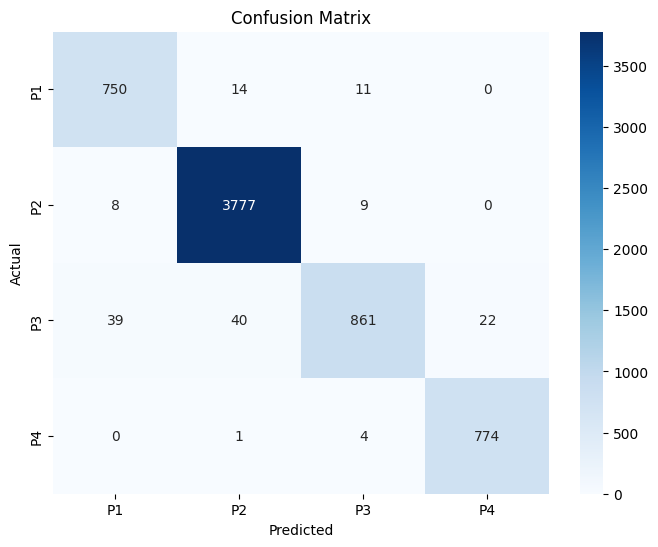

In [13]:
# Plot confusion matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('/content/cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()